In [11]:
import glob
import pickle
import gc
import os
import warnings
import tqdm
import splot
import random
import scprep as scp
import numpy as np
import pandas as pd
import scanpy as sc
import geopandas as gpd
import torchvision.transforms as tf
import torchvision.transforms.functional as TF
import squidpy as sq
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
warnings.filterwarnings("ignore")

from sklearn.metrics.pairwise import cosine_similarity
from libpysal.weights.contiguity import Queen
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran, Moran_Local
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation
from scipy.sparse import issparse
from scipy.stats import pearsonr, spearmanr
from skimage.metrics import structural_similarity as ssim
from Models.DeepPT import augment as aug_
from Dataloader.Dataset import *


In [15]:
def get_R(data1,data2, dim=1,func=pearsonr):
    adata1=data1.X
    adata2=data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2
    
    r1,p1=[],[]
    for g in range(data1.shape[1]):
        if dim==1:
            r,pv=func(adata1[:,g],adata2[:,g], alternative='greater')
        elif dim==0:
            r,pv=func(adata1[g,:],adata2[g,:], alternative='greater')
        r1.append(r)
        p1.append(pv)
    r1=np.array(r1)
    p1=np.array(p1)
    return r1,p1

def get_ssim(data1, data2, num_breaks=None):
    """
    Some info about SSIM computation.
    data1: the ground truth data
    data2: the predicted data
    dim: the dimension to calculate the SSIM. If the dim = 1, calculate the SSIM at gene-wise, otherwise calculate the SSIM at spot-wise.
    """
    adata1 = data1.X
    adata2 = data2.X

    # Check if the variables are sparse matrices or numpy arrays
    adata1 = adata1.toarray() if issparse(adata1) else adata1
    adata2 = adata2.toarray() if issparse(adata2) else adata2

    SSIM = []
    for g in range(adata1.shape[1]):
        x = adata1[:,g]
        y = adata2[:,g]
        # Normalize the arrays if their maximum values are not zero
        x = x if np.max(x) == 0 else x / np.max(x)
        y = y if np.max(y) == 0 else y / np.max(y)  
    
        if num_breaks:
            # Discretize the normalized arrays into 'num_breaks' bins
            x = np.digitize(x, np.linspace(0, 1, num_breaks), right=False) - 1
            y = np.digitize(y, np.linspace(0, 1, num_breaks), right=False) - 1
            
            # Constants used in SSIM calculation
            C1 = (0.01 * (num_breaks - 1))**2
            C2 = (0.03 * (num_breaks - 1))**2
        else:
            C1 = (0.01)**2
            C2 = (0.03)**2
        
        mux = np.mean(x)
        muy = np.mean(y) 
        sigxy = np.cov(x, y)[0, 1]
        sigx = np.var(x)
        sigy = np.var(y)
        
        ssim = ((2 * mux * muy + C1) * (2 * sigxy + C2)) / ((mux**2 + muy**2 + C1) * (sigx + sigy + C2))
        SSIM.append(ssim)
        assert -1 <= ssim <= 1, "SSIM should be within the valid range [-1, 1]"
        
    return SSIM

def get_MI(adata1, adata2, gene_list, spatial_matrix):
    moran_scores = []
    adata1.obsm["gpd"] = gpd.GeoDataFrame(adata1.obs, geometry=gpd.points_from_xy(spatial_matrix[:, 0], spatial_matrix[:, 1]))
    print("Calculate Moran's I score...")
    for gene in tqdm.tqdm(gene_list):
        x = adata1.to_df()[gene].values
        y = adata2.to_df()[gene].values
        w = Queen.from_dataframe(adata1.obsm["gpd"])
        moran_bv = Moran_BV(y, x, w)
        moran_scores.append(moran_bv.I)
    return moran_scores

def get_cosine(data1, data2):
    # Convert the anndata to numpy array
    adata1=data1.X.T
    adata2=data2.X.T
    # Calculate the consine similarity at gene wise
    cosine_sim = cosine_similarity(adata1, adata2)
    # Take the diag of similarity matrix
    cosine_score = np.diag(cosine_sim)
    return cosine_score

def top_predictable_genes(df_all, dataset, method, num=5,):
    """
    input the results from the make_res function.
    output the top predictable genes with the number of positive Pearson correlation values.
    num is the number of top predictable genes.
    """
    df = df_all[df_all["Method"]==method]
    if num == "pos":
        top5_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(['median', 'mean', 'max', 'min', 'std']).sort_values(by=('Pearson correlation', 'median'), ascending=False)
    else:
        top5_df = df[["Gene", "Pearson correlation"]].groupby("Gene", as_index=False).agg(['median', 'mean', 'max', 'min', 'std']).sort_values(by=('Pearson correlation', 'median'), ascending=False).head(num)
    top5_genes = list(top5_df.index)
    
    # Subset the results according to top predictable gene
    num_pos = []
    for g in top5_genes:
        subset_df = df[df["Gene"]==g]
        count_positive_corr = subset_df[subset_df['Pearson correlation'] > 0].shape[0]
        # print(f'Number of positive Pearson correlation values: {count_positive_corr}')
        num_pos.append(int(count_positive_corr))
    top5_df["Number of consistent samples"] = num_pos
    top5_df["Method"] = method
    top5_df["Dataset"] = dataset
    top5_df = top5_df[[(           'Method',       ''),
            (                     'Dataset',       ''),
            ('Number of consistent samples',       ''),
            (         'Pearson correlation',   'mean'),
            (         'Pearson correlation', 'median'),
            (         'Pearson correlation', 'min'),
            (         'Pearson correlation',    'max'),
            (         'Pearson correlation',    'std'),
            
            ]]

    return top5_df


def make_res(fold, augment, exp_norm, names):
    """
    input the dataset name, colornorm, methods, and names of the slides
    output the results of the methods with three metrics: Pearson correlation, Spearman correlation, and SSIM score
    """
    gc.collect()
    name = names[fold]
    file_path = f"../Results/preprocessing/pred_deeppt_{augment}_{exp_norm}_raw_{name}_hvg.h5ad"
    if os.path.exists(file_path):
        data1 = sc.read_h5ad(f"../Results/preprocessing/pred_deeppt_{augment}_{exp_norm}_raw_{name}_hvg.h5ad")
        data2 = sc.read_h5ad(f"../Results/preprocessing/gt_deeppt_{augment}_{exp_norm}_raw_{name}_hvg.h5ad")
        # spatial_matrix = np.load(f"../Results/preprocessing/spatial_loc_deeppt_{augment}_{exp_norm}_raw_{name}_hvg.npy")
        pcc, PCC_PValue = get_R(data1, data2, dim=1, func=pearsonr)
        SPC, SPC_PValue = get_R(data1, data2, dim=1, func=spearmanr)
        ssim_score = get_ssim(data1, data2)
        cosine_score = get_cosine(data1, data2)
        data1.var_names = data2.var_names
        # MI = get_MI(data1, data2, list(data1.var_names), spatial_matrix)
        PCC_BC_Visium = {
        "Gene": list(data1.var_names),
        "Pearson correlation": pcc,
        "PCC_PValue": PCC_PValue,
        "Spearmanr correlation": SPC,
        "SPC_PValue": SPC_PValue,
        "SSIM_Score": ssim_score,
        "Cosine_Score": cosine_score,
        # "Moran'I_Score": MI,
        "Slides": [name]*len(pcc),
        "Image_transformation": [augment]*len(pcc),
        "Expression_normalization": [exp_norm]*len(pcc),}
        
        PCC_BC_Visium = pd.DataFrame(PCC_BC_Visium)
        if not os.path.isdir(f"../Results/preprocessing"):
            os.mkdir(f"../Results/preprocessing")
        PCC_BC_Visium.to_csv(f"../Results/preprocessing/deeppt_{augment}_{exp_norm}_raw_{name}_hvg.csv")
    else:
        print(f"The file {file_path} does not exist. Skipping.")
    print("Organize the results into summary file!")
    res = glob.glob(f"../Results/preprocessing/*_hvg.csv")
    df = pd.concat([pd.read_csv(i, index_col=[0]) for i in res])
    df.reset_index(inplace=True)
    df.to_csv(f"../Results/Summary/preprocessing_summary_hvg.csv")
    return df

# Color normalization
target = cv2.cvtColor(cv2.imread(f"../Dataset/Reference_Normalization/ref_HE.png"), cv2.COLOR_BGR2RGB)
def color_normalization(img, target, method="macenko"):
    """
    img: numpy array, RGB image
    method: str, "raw", "macenko" or "reinhard"
    target: numpy array, RGB image
    """

    T = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Lambda(lambda x: x*255)
    ])
    if method == "macenko":
        Normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
        Normalizer.fit(T(target))
        img, Macenko_H, Macenko_E = Normalizer.normalize(I=T(img), stains=True)
    elif method == "reinhard":
        Normalizer = torchstain.normalizers.ReinhardNormalizer(backend='torch')
        Normalizer.fit(T(target))
        img = Normalizer.normalize(I=T(img))
    elif method == "raw":
        img = img
    return img

def aug(image, trans):
    # Randomly select one augmentation
    selected_augmentation = trans

    # Apply the selected augmentation
    if selected_augmentation == "blur":
        # Gassian blur
        image = tf.GaussianBlur(kernel_size=7, sigma=(1, 1.5))(image)

    elif selected_augmentation == "random_grayscale":
        # Random grayscale
        image = tf.RandomGrayscale(1.0)(image)
        
    elif selected_augmentation == "random_rotation":
        # Random flipping and rotations
        if random.random() > 0.5:
            image = TF.hflip(image)
        if random.random() > 0.5:
            image = TF.vflip(image)
        if random.random() > 0.5:
            image = TF.rotate(image, random.choice([180, 90, 0, -90]))
    elif selected_augmentation == "reinhard":
        # Color normalization
        image = torch.tensor(color_normalization(image.permute(1,2,0).numpy(), target, method="reinhard")).permute(2,0,1)

    elif selected_augmentation == "none":
        # No augmentation
        pass
    return image

# Gene expression preprocessing
def expression_normalization(exp, exp_norm, target_gene_list):
    print("length of target genes:", len(target_gene_list))
    if exp_norm == "raw":
        exp_new = exp[target_gene_list].values.astype(np.float64) 
    elif exp_norm == "lognorm":
        exp_new = scp.transform.log(scp.normalize.library_size_normalize(exp[target_gene_list].values)).astype(np.float64)
    elif exp_norm == "norm":
        exp_new = scp.normalize.library_size_normalize(exp[target_gene_list].values).astype(np.float64)
    elif exp_norm == "log1p":
        exp_new = scp.transform.log(exp[target_gene_list].values).astype(np.float64)
    elif exp_norm == "minmax":
        exp_new = MinMaxScaler().fit_transform(exp[target_gene_list].values).astype(np.float64)
    exp_new = sc.AnnData(exp_new)
    exp_new.var_names = target_gene_list
    return exp_new

## Figure S9 a)

In [2]:
dataset_name = "Skin_cSCC"
target_gene_list = np.load(f"../Dataset/Gene_list/Gene_list_func_{dataset_name}.npy", allow_pickle=True)
te_data = CSCC(train=False, fold=1, r=112, num_subsets=1,
                            neighs=4, color_norm="raw", exp_norm="log1p",
                            gene_list=target_gene_list)

['P2_ST_rep2']
Loading imgs...


100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


Loading metadata...


100%|██████████| 1/1 [00:12<00:00, 12.83s/it]


subset_size: 646
Loading gene expression
Croping WSI into patches...


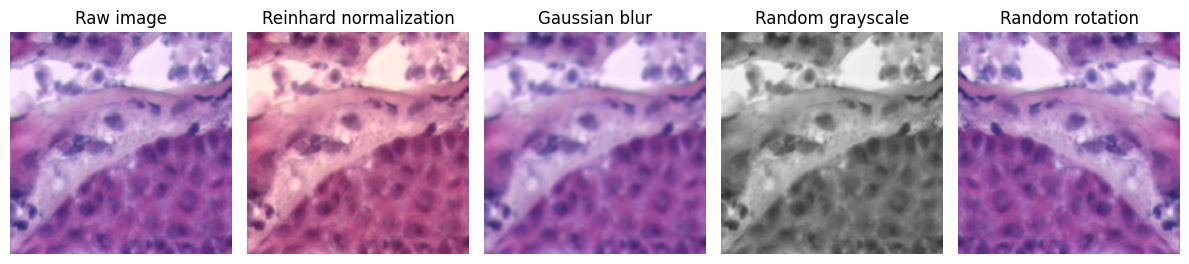

24982

In [10]:
img = te_data[0][0][15]
trans = ["none", "reinhard", "blur", "random_grayscale", "random_rotation" ]

# Create a 1x4 subplot grid
fig, axes = plt.subplots(1, 5, figsize=(12, 6))

# Iterate over transformations
for i, tran in enumerate(trans):
    aug_img = aug(img, tran).cpu().numpy()

    if len(aug_img.shape) == 4:
        aug_img = aug_img.squeeze(0).transpose(1, 2, 0) / 255
    else:
        aug_img = aug_img.transpose(1, 2, 0) / 255.0
    
    if tran == "blur":
        tran = "Gaussian blur"
    elif tran == "random_grayscale":
        tran = "Random grayscale"
    elif tran == "random_rotation":
        tran = "Random rotation"
    elif tran == "reinhard":
        tran = "Reinhard normalization"
    elif tran == "template":
        tran = "Template"
    elif tran == "none":
        tran = "Raw image"

    # Plot each augmented image
    axes[i].imshow(aug_img)
    axes[i].set_title(tran)
    axes[i].axis('off')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # rect parameter to leave space for the common title

# Show the plot
plt.show()
gc.collect()


## Figure S9 b)

In [13]:
adatas = []
target_gene_list = np.load(f"../Dataset/Gene_list/Gene_list_func_Skin_cSCC.npy", allow_pickle=True)
for i in range(1):
    gc.collect()
    te_data = CSCC(train=False, fold=i, r=112, num_subsets=1,
                    neighs=4, color_norm="raw", exp_norm="raw",
                    gene_list=target_gene_list)
    adata_dict = te_data.meta_dict
    adatas.append(adata_dict[list(adata_dict.keys())[0]])

['P2_ST_rep1']
Loading imgs...


100%|██████████| 1/1 [00:03<00:00,  3.20s/it]


Loading metadata...


100%|██████████| 1/1 [00:13<00:00, 13.05s/it]


subset_size: 666
Loading gene expression
Croping WSI into patches...


In [ ]:
# Concatenate all adata
adata_cat = ad.concat(adatas).copy()
adata_cat.write_h5ad(f"Skin_cSCC_test.h5ad")

# Convert adata to df
exp = adata_cat.to_df()

# find the index of target gene
index = exp[target_gene_list].columns.get_loc("PFN1")

# Functional genes
target_gene_list = np.load(f"../Dataset/Gene_list/Gene_list_func_Skin_cSCC.npy", allow_pickle=True) # change the path to your local path

# Gene expression preprocessing
exp_raw = expression_normalization(exp, "raw", target_gene_list)
exp_norm = expression_normalization(exp, "norm", target_gene_list)
exp_log = expression_normalization(exp, "log1p", target_gene_list)
exp_lognorm = expression_normalization(exp, "lognorm", target_gene_list)
exp_minmax = expression_normalization(exp, "minmax", target_gene_list)

# Convert the numpy array to dataframe
x = pd.DataFrame({"Raw": exp_raw.to_df().iloc[:,index]})
x["Norm"] = exp_norm.to_df().iloc[:,index]
x["Log1p"] = exp_log.to_df().iloc[:,index]
x["LogNorm"] = exp_lognorm.to_df().iloc[:,index]
x["MinMax"] = exp_minmax.to_df().iloc[:,index]

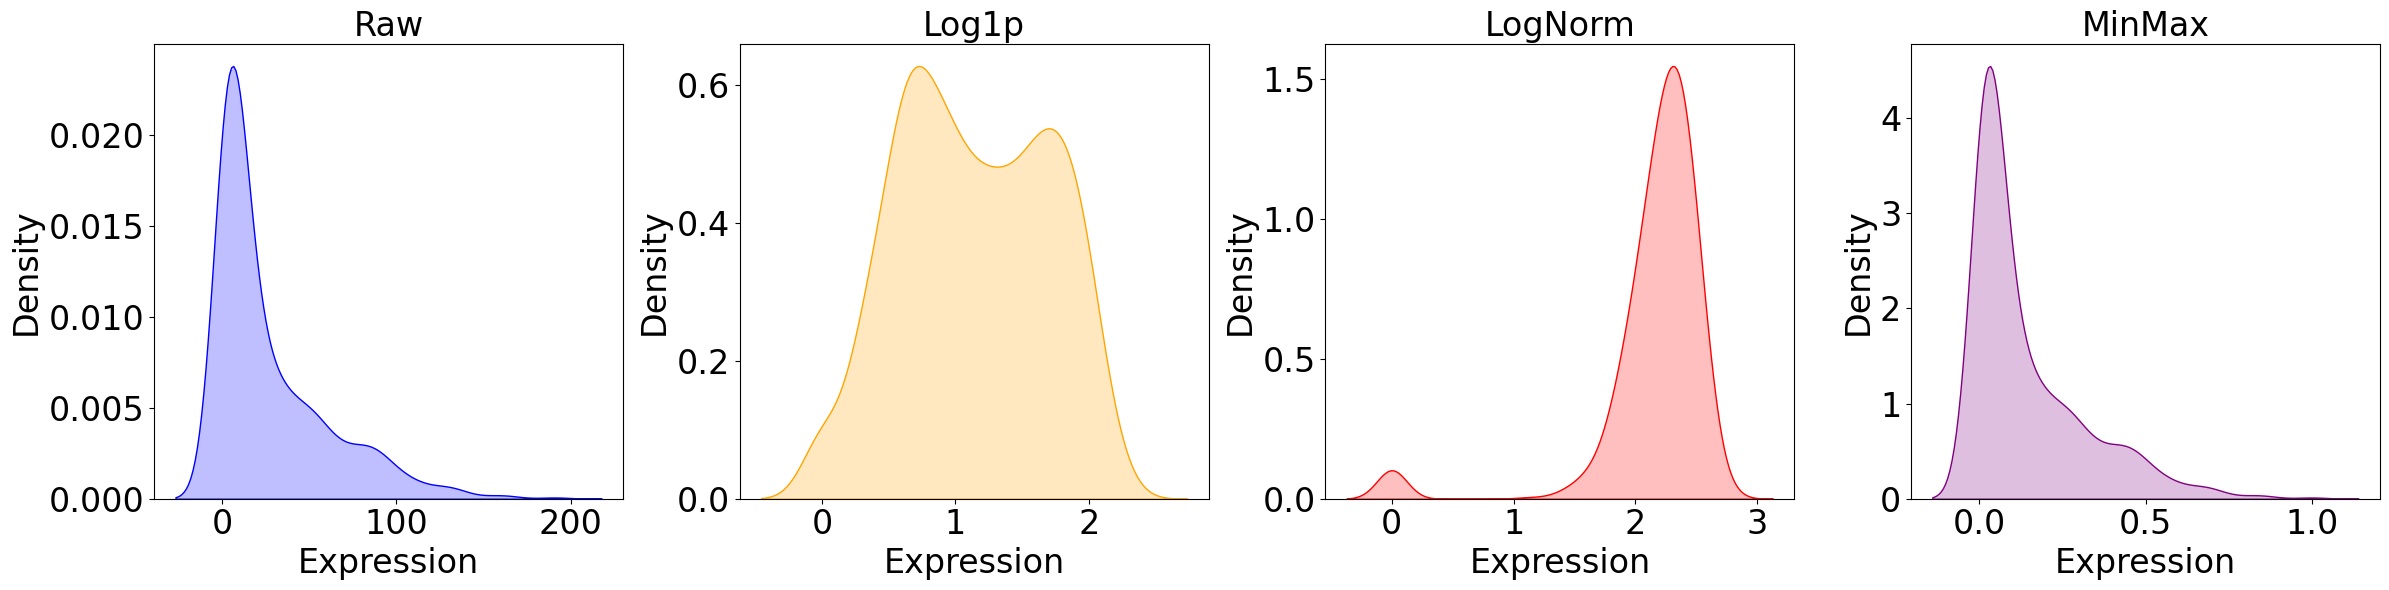

In [19]:
# Create a 1x5 subplot grid with a larger overall figure size
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# List of methods and corresponding colors
methods = ['Raw', 'Log1p', 'LogNorm', 'MinMax']
colors = ['blue', 'orange', 'red', 'purple']

# Iterate over methods
for i, method in enumerate(methods):
    # Specify color for each method
    sns.kdeplot(data=x[method], common_norm=False, fill=True, ax=axes[i], color=colors[i])

    # Set titles and labels
    axes[i].set_title(method, fontsize=24)
    axes[i].set_xlabel('Expression', fontsize=24)
    axes[i].set_ylabel('Density', fontsize=24)

    # Customize tick labels
    axes[i].tick_params(axis='both', which='both', labelsize=24)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()
gc.collect()


## Figure S9 d)

In [30]:
# Read the method names
names = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']
names.sort()

# # Benchmarking augmentation methods
# for augment in ["reinhard", "blur", "random_grayscale", "random_rotation", "none"]: 
#     for fold in range(12):
#         exp_norm = "log1p"
#         print(f"Sample names:{names}")
#         print(f"Sample name:{names[fold]}")
#         print(f"fold:{fold}")
#         print(f"augment:{augment}")
#         print(f"exp_norm:{exp_norm}")

#         # Organize the results into dataframe
#         df = make_res(fold, augment, exp_norm, names)

# Benchmarking expression normalization methods
for exp_norm in ["norm"]: # "raw", "log1p", "lognorm", "minmax", 
    for fold in range(12):
        augment = "none"
        print(f"Sample names:{names}")
        print(f"Sample name:{names[fold]}")
        print(f"fold:{fold}")
        print(f"augment:{augment}")
        print(f"exp_norm:{exp_norm}")

        # Organize the results into dataframe
        df = make_res(fold, augment, exp_norm, names)

Sample names:['P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3', 'P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 'P9_ST_rep3']
Sample name:P10_ST_rep1
fold:0
augment:none
exp_norm:norm
Organize the results into summary file!
Sample names:['P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3', 'P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 'P9_ST_rep3']
Sample name:P10_ST_rep2
fold:1
augment:none
exp_norm:norm
Organize the results into summary file!
Sample names:['P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3', 'P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 'P9_ST_rep3']
Sample name:P10_ST_rep3
fold:2
augment:none
exp_norm:norm
Organize the results into summary file!
Sample names:['P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3', 'P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_r

In [2]:
df = pd.read_csv(f"../Results/Summary/preprocessing_summary_hvg.csv")
df


,Unnamed: 0,index,Gene,Pearson correlation,PCC_PValue,Spearmanr correlation,SPC_PValue,SSIM_Score,Cosine_Score,Slides,Image_transformation,Expression_normalization
0,0,0,PPP1R12A,0.240466,9.265636e-17,0.200161,4.554359e-12,0.189147,0.479845,P9_ST_rep1,random_grayscale,log1p
1,1,1,S100P,0.280864,2.063285e-22,0.232428,9.465172e-16,0.225798,0.514861,P9_ST_rep1,random_grayscale,log1p
2,2,2,IMP4,0.395407,2.890230e-44,0.263526,7.258786e-20,0.209619,0.460858,P9_ST_rep1,random_grayscale,log1p
3,3,3,KRT2,0.247737,1.050628e-17,0.110900,8.774930e-05,0.060471,0.361859,P9_ST_rep1,random_grayscale,log1p
4,4,4,SOX4,0.317998,1.669502e-28,0.267120,2.229341e-20,0.255756,0.609828,P9_ST_rep1,random_grayscale,log1p
...,...,...,...,...,...,...,...,...,...,...,...,...
18463,18463,166,DDX18,0.030272,2.475793e-01,0.025408,2.834997e-01,0.025094,0.348285,P5_ST_rep2,none,log1p
18464,18464,167,FLG,0.264281,6.731541e-10,0.183254,1.566273e-05,0.256717,0.713180,P5_ST_rep2,none,log1p
18465,18465,168,NEMF,0.105832,8.404054e-03,0.103306,9.811172e-03,0.062585,0.419995,P5_ST_rep2,none,log1p
18466,18466,169,DYNC1I2,0.045554,1.522678e-01,0.065357,7.025119e-02,0.039469,0.512284,P5_ST_rep2,none,log1p


In [3]:
expression_norm = df[df["Image_transformation"]=="none"]
expression_norm.groupby(["Expression_normalization"]).agg({"Pearson correlation": ["median", "mean", "min", "max", "std"]}).sort_values(by=("Pearson correlation", "median"), ascending=False).sort_index(level=0)


Pearson correlation                                \
                                      median      mean       min       max   
Expression_normalization                                                     
log1p                               0.290160  0.314486 -0.058683  0.834745   
lognorm                             0.135521  0.152008 -0.091265  0.508891   
minmax                              0.239239  0.259724 -0.086160  0.770727   
norm                                0.029039  0.047485 -0.329029  0.668265   
raw                                 0.266810  0.288692 -0.142049  0.867050   

                                    
                               std  
Expression_normalization            
log1p                     0.199340  
lognorm                   0.107688  
minmax                    0.184986  
norm                      0.097868  
raw                       0.190114

In [4]:
img_trans = df[df["Image_transformation"]!="none"]
baseline = df[(df["Image_transformation"]=="none") & (df["Expression_normalization"]=="log1p")]
img_trans = pd.concat([img_trans, baseline])
img_trans.groupby(["Image_transformation"]).agg({"Pearson correlation": ["median", "mean", "min", "max", "std"]}).sort_values(by=("Pearson correlation", "median"), ascending=False).sort_index(level=0)


Pearson correlation                                \
                                  median      mean       min       max   
Image_transformation                                                     
blur                            0.306971  0.313713 -0.099798  0.841669   
none                            0.290160  0.314486 -0.058683  0.834745   
random_grayscale                0.316890  0.317913 -0.111005  0.847523   
random_rotation                 0.319598  0.327690 -0.102043  0.839881   
reinhard                        0.301277  0.323224 -0.105180  0.859490   

                                
                           std  
Image_transformation            
blur                  0.191716  
none                  0.199340  
random_grayscale      0.204922  
random_rotation       0.196669  
reinhard              0.200176

In [5]:
method_mapping = {
    'random_grayscale': "Random grayscale",
    'none': "Without augmentation",
    'blur': "Gaussian blur",
    'random_rotation': "Random rotation",
    'reinhard': "Reinhard color normalization",
}

# Replace model and dataset names in the DataFrame
img_trans.replace({'Image_transformation': method_mapping}, inplace=True)

# Define the order for Dataset and Method columns
method_order = ['Without augmentation', 'Random grayscale', 'Reinhard color normalization', 'Gaussian blur', 'Random rotation']

# Use pd.Categorical directly during DataFrame creation
img_trans['Image_transformation'] = pd.Categorical(img_trans['Image_transformation'], categories=method_order, ordered=True)

In [ ]:
# # Create a 1x4 subplot grid
# fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)

# # Plot the first boxplot
# sns.boxplot(data=img_trans, x="Slides", hue="Image_transformation", y="Pearson correlation", showfliers=False, ax=axes[0])
# axes[0].get_legend().remove()
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=30, fontsize='x-large')  # Rotate x-axis labels
# axes[0].set_ylabel("Pearson correlation", fontsize='x-large')  # Set y-axis label

# # Plot the second boxplot
# sns.boxplot(data=img_trans, x="Slides", hue="Image_transformation", y="Spearmanr correlation", showfliers=False, ax=axes[1])
# axes[1].get_legend().remove()
# axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=30, fontsize='x-large')  # Rotate x-axis labels
# axes[1].set_ylabel("Spearmanr correlation", fontsize='x-large')  # Set y-axis label

# # Plot the third boxplot (I assume this is supposed to be a different metric, change as needed)
# sns.boxplot(data=img_trans, x="Slides", hue="Image_transformation", y="SSIM_Score", showfliers=False, ax=axes[2])
# axes[2].get_legend().remove()
# axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=30, fontsize='x-large')  # Rotate x-axis labels
# axes[2].set_ylabel("SSIM_Score", fontsize='x-large')  # Set y-axis label

# # Plot the fourth boxplot
# sns.boxplot(data=img_trans, x="Slides", hue="Image_transformation", y="Cosine_Score", showfliers=False, ax=axes[3])
# axes[3].get_legend().remove()
# axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=30, fontsize='x-large')  # Rotate x-axis labels
# axes[3].set_ylabel("Cosine_Score", fontsize='x-large')  # Set y-axis label

# # Adjust title fontsize
# for ax in axes:
#     ax.title.set_fontsize('x-large')

# # Adjust legend fontsize
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels), fontsize='x-large')

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()
# gc.collect()


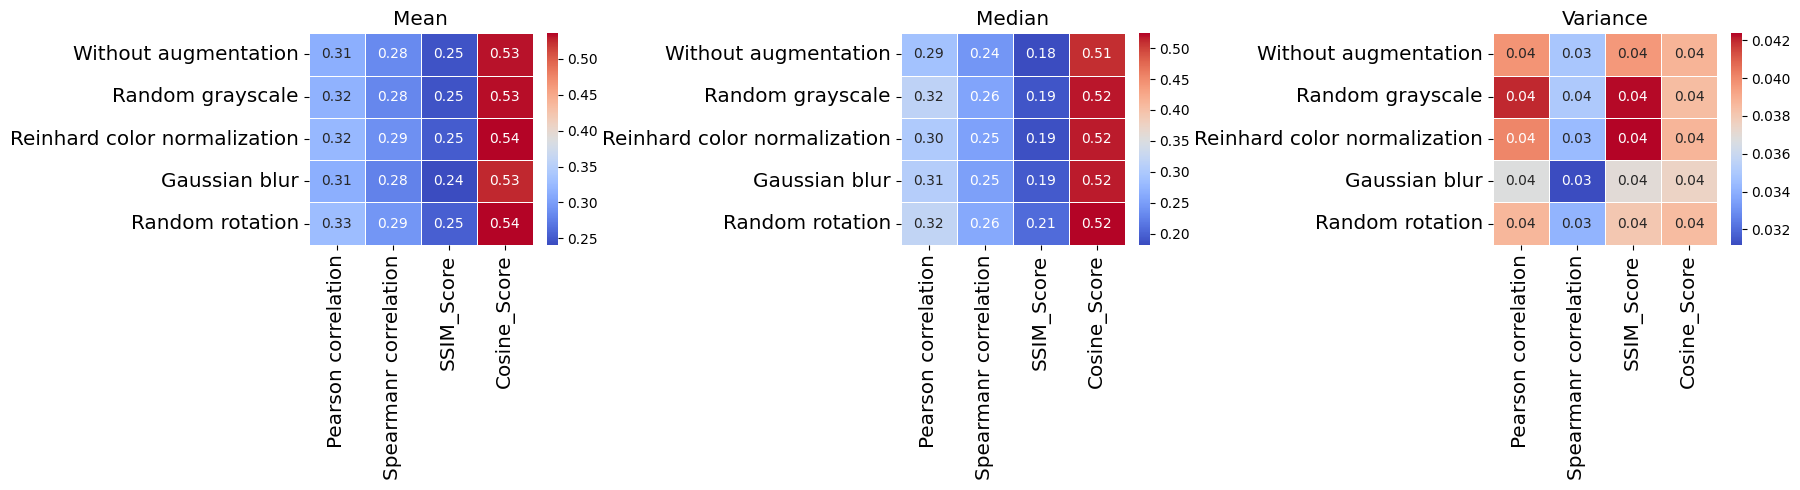

In [88]:
# Create a 1x3 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Mean heatmap
grouped_data_mean = img_trans.groupby('Image_transformation').agg({
    'Pearson correlation': 'mean',
    'Spearmanr correlation': 'mean',
    'SSIM_Score': 'mean',
    'Cosine_Score': 'mean',
})
columns_to_visualize = ['Pearson correlation', 'Spearmanr correlation', 'SSIM_Score', 'Cosine_Score']

sns.heatmap(grouped_data_mean[columns_to_visualize], annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=axes[0])
axes[0].set_title("Mean", fontsize='x-large')
axes[0].set_ylabel("", fontsize='x-large')  # Set y-axis label
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize='x-large')  # Rotate x-axis labels
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize='x-large')  # Rotate x-axis labels

# Median heatmap
grouped_data_median = img_trans.groupby('Image_transformation').agg({
    'Pearson correlation': 'median',
    'Spearmanr correlation': 'median',
    'SSIM_Score': 'median',
    'Cosine_Score': 'median',
})
columns_to_visualize = ['Pearson correlation', 'Spearmanr correlation', 'SSIM_Score', 'Cosine_Score']

sns.heatmap(grouped_data_median[columns_to_visualize], annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=axes[1])
axes[1].set_title("Median", fontsize='x-large')
axes[1].set_ylabel("", fontsize='x-large')  # Set y-axis label
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize='x-large')  # Rotate x-axis labels
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize='x-large')  # Rotate x-axis labels

# Variance heatmap
grouped_data_var = img_trans.groupby('Image_transformation').agg({
    'Pearson correlation': 'var',
    'Spearmanr correlation': 'var',
    'SSIM_Score': 'var',
    'Cosine_Score': 'var',
})
columns_to_visualize = ['Pearson correlation', 'Spearmanr correlation', 'SSIM_Score', 'Cosine_Score']

sns.heatmap(grouped_data_var[columns_to_visualize], annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=axes[2])
axes[2].set_title("Variance", fontsize='x-large')
axes[2].set_ylabel("", fontsize='xx-large')  # Set y-axis label
axes[2].set_xticklabels(axes[2].get_xticklabels(), fontsize='x-large')  # Rotate x-axis labels
axes[2].set_yticklabels(axes[2].get_yticklabels(), fontsize='x-large')  # Rotate x-axis labels



# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Figure S9 e)

In [6]:
method_mapping = {
    'log1p': "Log transformation",
    'minmax': "Minmax scaling",
    'lognorm': "Log transformation + Normalization",
    # 'norm': "Normalization",
    'raw': "Without preprocessing"
}

# Replace model and dataset names in the DataFrame
expression_norm.replace({'Expression_normalization': method_mapping}, inplace=True)

# Define the order for Dataset and Method columns
method_order = ['Without preprocessing', 'Minmax scaling', 'Log transformation', 'Log transformation + Normalization', ] # 'Normalization'
slides_order = ['P2_ST_rep1', 'P2_ST_rep2', 'P2_ST_rep3', 'P5_ST_rep1', 
         'P5_ST_rep2', 'P5_ST_rep3', 'P9_ST_rep1', 'P9_ST_rep2', 
         'P9_ST_rep3', 'P10_ST_rep1', 'P10_ST_rep2', 'P10_ST_rep3']

# Use pd.Categorical directly during DataFrame creation
expression_norm['Expression_normalization'] = pd.Categorical(expression_norm['Expression_normalization'], categories=method_order, ordered=True)
expression_norm['Slides'] = pd.Categorical(expression_norm['Slides'], categories=slides_order, ordered=True)


In [ ]:
# # Create a 1x4 subplot grid
# fig, axes = plt.subplots(1, 4, figsize=(24, 5), sharey=True)

# # Plot the first boxplot
# sns.boxplot(data=expression_norm, x="Slides", hue="Expression_normalization", y="Pearson correlation", showfliers=False, ax=axes[0])
# axes[0].get_legend().remove()
# axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=35, fontsize='xx-large')  # Rotate x-axis labels
# axes[0].set_ylabel("Pearson correlation", fontsize='xx-large')  # Set y-axis label
# axes[0].set_xlabel("", fontsize='xx-large')  # Set y-axis label

# # Plot the second boxplot
# sns.boxplot(data=expression_norm, x="Slides", hue="Expression_normalization", y="Spearmanr correlation", showfliers=False, ax=axes[1])
# axes[1].get_legend().remove()
# axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=35, fontsize='xx-large')  # Rotate x-axis labels
# axes[1].set_ylabel("Spearmanr correlation", fontsize='xx-large')  # Set y-axis label
# axes[1].set_xlabel("", fontsize='xx-large')  # Set y-axis label

# # Plot the third boxplot (I assume this is supposed to be a different metric, change as needed)
# sns.boxplot(data=expression_norm, x="Slides", hue="Expression_normalization", y="SSIM_Score", showfliers=False, ax=axes[2])
# axes[2].get_legend().remove()
# axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=35, fontsize='xx-large')  # Rotate x-axis labels
# axes[2].set_ylabel("SSIM_Score", fontsize='x-large')  # Set y-axis label
# axes[2].set_xlabel("", fontsize='xx-large')  # Set y-axis label


# # Plot the fourth boxplot
# sns.boxplot(data=expression_norm, x="Slides", hue="Expression_normalization", y="Cosine_Score", showfliers=False, ax=axes[3])
# axes[3].get_legend().remove()
# axes[3].set_xticklabels(axes[3].get_xticklabels(), rotation=35, fontsize='x-large')  # Rotate x-axis labels
# axes[3].set_ylabel("Cosine_Score", fontsize='xx-large')  # Set y-axis label
# axes[3].set_xlabel("", fontsize='xx-large')  # Set y-axis label


# # Adjust title fontsize
# for ax in axes:
#     ax.title.set_fontsize('xx-large')

# # Adjust legend fontsize
# handles, labels = axes[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=len(labels), fontsize='xx-large')

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()
# gc.collect()


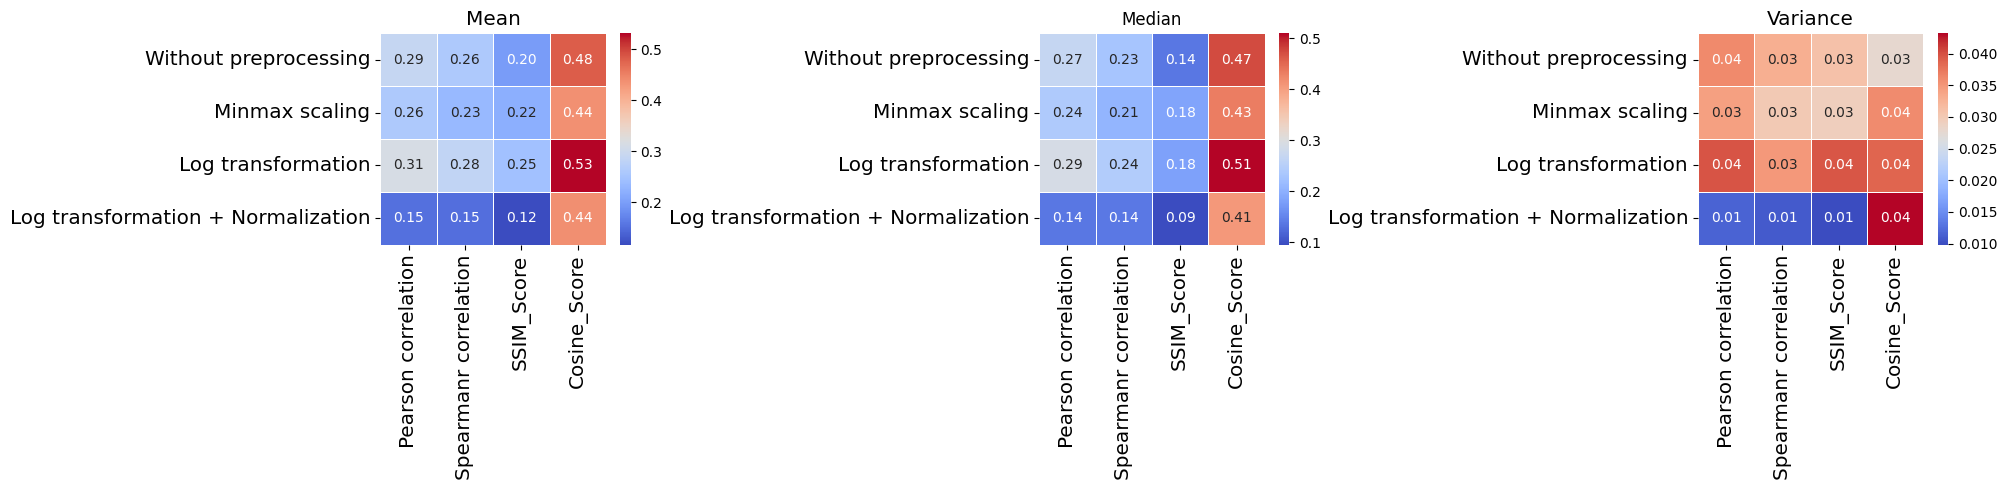

In [7]:
# Create a 1x3 subplot grid
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Mean heatmap
grouped_data_mean = expression_norm.groupby('Expression_normalization').agg({
    'Pearson correlation': 'mean',
    'Spearmanr correlation': 'mean',
    'SSIM_Score': 'mean',
    'Cosine_Score': 'mean',
})
columns_to_visualize = ['Pearson correlation', 'Spearmanr correlation', 'SSIM_Score', 'Cosine_Score']

sns.heatmap(grouped_data_mean[columns_to_visualize], annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=axes[0])
axes[0].set_title("Mean", fontsize='x-large')
axes[0].set_ylabel("", fontsize='x-large')  # Set y-axis label
axes[0].set_xticklabels(axes[0].get_xticklabels(), fontsize='x-large')  # Rotate x-axis labels
axes[0].set_yticklabels(axes[0].get_yticklabels(), fontsize='x-large')  # Rotate x-axis labels

# Median heatmap
grouped_data_median = expression_norm.groupby('Expression_normalization').agg({
    'Pearson correlation': 'median',
    'Spearmanr correlation': 'median',
    'SSIM_Score': 'median',
    'Cosine_Score': 'median',
})
columns_to_visualize = ['Pearson correlation', 'Spearmanr correlation', 'SSIM_Score', 'Cosine_Score']

sns.heatmap(grouped_data_median[columns_to_visualize], annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=axes[1])
axes[1].set_title("Median")
axes[1].set_ylabel("", fontsize='x-large')  # Set y-axis label
axes[1].set_xticklabels(axes[1].get_xticklabels(), fontsize='x-large')  # Rotate x-axis labels
axes[1].set_yticklabels(axes[1].get_yticklabels(), fontsize='x-large')  # Rotate x-axis labels

# Variance heatmap
grouped_data_var = expression_norm.groupby('Expression_normalization').agg({
    'Pearson correlation': 'var',
    'Spearmanr correlation': 'var',
    'SSIM_Score': 'var',
    'Cosine_Score': 'var',
})
columns_to_visualize = ['Pearson correlation', 'Spearmanr correlation', 'SSIM_Score', 'Cosine_Score']

sns.heatmap(grouped_data_var[columns_to_visualize], annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5, ax=axes[2])
axes[2].set_title("Variance", fontsize='x-large')
axes[2].set_ylabel("", fontsize='x-large')  # Set y-axis label
axes[2].set_xticklabels(axes[2].get_xticklabels(), fontsize='x-large')  # Rotate x-axis labels
axes[2].set_yticklabels(axes[2].get_yticklabels(), fontsize='x-large')  # Rotate x-axis labels

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()
